# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pprint import pprint
from prettytable import PrettyTable

In [2]:
# sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, NuSVC
from scipy.stats import mode
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
from catboost import CatBoostClassifier

In [12]:
import warnings 
warnings.filterwarnings("ignore")

# Initialisation

In [3]:
naive_sub= pd.read_csv('forest/naive_submission.csv')
df= pd.read_csv('forest/train.csv').drop('Unnamed: 0',axis=1)
test= pd.read_csv('forest/test.csv').drop('row_ID',axis=1)

## Prétraitement des données

In [5]:
# Variable qualitative ou quantitative
# Toutes les variables sont quantitatives, à part Soil_Type et Wilderness_Area
columns= df.columns
quantitative_vars = columns[:10]
qual_vars = columns[10:]
qualitative_vars = [item.rsplit('_')[1] for item in qual_vars if item != 'Cover_Type']

In [6]:
# Filtre les données en fonction des quantiles calculés pour chaque variable
# Définition d'un nouveau dataframe df_filtered
df_filtered = df.copy()

for col in quantitative_vars:
    Q3 = df_filtered[col].quantile(0.85)
    Q1 = df_filtered[col].quantile(0.15)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
df_filtered_long = pd.melt(df_filtered, var_name='Variables', value_name='Values')

# Classification

## Feature scaling

In [8]:
df_filtered = df_filtered.reset_index(drop=True)

### Données one hot encoded ###
X = df_filtered.drop('Cover_Type',axis=1)
y = df_filtered['Cover_Type']

In [9]:
# Normalise les données
ct_s = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(), quantitative_vars)
    ],
    remainder='passthrough'
)

X_ss = ct_s.fit_transform(X)

# Standardise avec méthode Min-Max
ct_m = ColumnTransformer(
    transformers=[
        ('standardize', MinMaxScaler(), quantitative_vars)
    ],
    remainder='passthrough'
)

X_mm = ct_m.fit_transform(X)

Séparation des données train-test

In [10]:
# Partionnement test-train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X, y, test_size=0.3, random_state=42)

features = X_train.columns

## Entraînement modèles sans configuration

In [13]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=300),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "XGBoost": XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=0),
    "CatBoost": CatBoostClassifier(random_seed=42, verbose=0),
    "Extra Trees Classifier": ExtraTreesClassifier(random_state=42)
}

### No scaling

In [14]:
accuracy_scores_default = {}
precision_scores_default = {}
recall_scores_default = {}
f1_scores_default = {}

for method, model in models.items():
    print(method)
    if method == 'SVC':
        index = np.random.randint(0, len(X_train), 5000)
        X_train_subset = X_train.iloc[index]
        y_train_subset = y_train.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        # XGBoost demande à ce que les labels commencent à 0
        base_model = model.fit(X_train, y_train-1)
    else:
        base_model = model.fit(X_train, y_train)

    if method == 'XGBoost':
        y_pred = base_model.predict(X_test) + 1
    else:
        y_pred = base_model.predict(X_test)
    
    # Calculate metrics correctly with y_test first
    accuracy_scores_default[method] = accuracy_score(y_test, y_pred)
    precision_scores_default[method] = precision_score(y_test, y_pred, average='weighted')
    recall_scores_default[method] = recall_score(y_test, y_pred, average='weighted')
    f1_scores_default[method] = f1_score(y_test, y_pred, average='weighted')

Logistic Regression
Random Forest Classifier
SVC
XGBoost
LightGBM
CatBoost
Extra Trees Classifier


### Données normalisées

In [15]:
# Sur données Standardisées

accuracy_scores_default_ss = {}
precision_scores_default_ss = {}
recall_scores_default_ss = {}
f1_scores_default_ss = {}

for method, model in models.items():
    print(method)
    if method == 'SVC':
        index = np.random.randint(0, len(X_train_ss), 5000)
        X_train_subset = X_train_ss.iloc[index]
        y_train_subset = y_train.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        # XGBoost demande à ce que les labels commencent à 0
        base_model = model.fit(X_train_ss, y_train-1)
    else:
        base_model = model.fit(X_train_ss, y_train)

    if method == 'XGBoost':
        y_pred = base_model.predict(X_test_ss) + 1
    else:
        y_pred = base_model.predict(X_test_ss)
    
    # Calculate metrics correctly with y_test first
    accuracy_scores_default_ss[method] = accuracy_score(y_test, y_pred)
    precision_scores_default_ss[method] = precision_score(y_test, y_pred, average='weighted')
    recall_scores_default_ss[method] = recall_score(y_test, y_pred, average='weighted')
    f1_scores_default_ss[method] = f1_score(y_test, y_pred, average='weighted')

Logistic Regression
Random Forest Classifier
SVC
XGBoost
LightGBM
CatBoost
Extra Trees Classifier


### Données Min-Max

In [16]:
# Sur données Min-Max

accuracy_scores_default_mm = {}
precision_scores_default_mm = {}
recall_scores_default_mm = {}
f1_scores_default_mm = {}

for method, model in models.items():
    print(method)
    if method == 'SVC':
        index = np.random.randint(0, len(X_train_mm), 5000)
        X_train_subset = X_train_mm.iloc[index]
        y_train_subset = y_train.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        # XGBoost demande à ce que les labels commencent à 0
        base_model = model.fit(X_train_mm, y_train-1)
    else:
        base_model = model.fit(X_train_mm, y_train)

    if method == 'XGBoost':
        y_pred = base_model.predict(X_test_mm) + 1
    else:
        y_pred = base_model.predict(X_test_mm)
    
    # Calculate metrics correctly with y_test first
    accuracy_scores_default_mm[method] = accuracy_score(y_test, y_pred)
    precision_scores_default_mm[method] = precision_score(y_test, y_pred, average='weighted')
    recall_scores_default_mm[method] = recall_score(y_test, y_pred, average='weighted')
    f1_scores_default_mm[method] = f1_score(y_test, y_pred, average='weighted')

Logistic Regression
Random Forest Classifier
SVC
XGBoost
LightGBM
CatBoost
Extra Trees Classifier


## Performances et comparaisons

In [17]:
# Toutes les métriques
table = PrettyTable()

table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']

for model in accuracy_scores_default.keys():
    table.add_row([model, accuracy_scores_default.get(model, '-'), precision_scores_default.get(model, '-'), recall_scores_default.get(model, '-'), f1_scores_default.get(model, '-')])

# Print the table
print(table)

table = PrettyTable()

table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']

for model in accuracy_scores_default_ss.keys():
    table.add_row([model, accuracy_scores_default_ss.get(model, '-'), precision_scores_default_ss.get(model, '-'), recall_scores_default_ss.get(model, '-'), f1_scores_default_ss.get(model, '-')])

# Print the table
print(table)

table = PrettyTable()

table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']

for model in accuracy_scores_default_mm.keys():
    table.add_row([model, accuracy_scores_default_mm.get(model, '-'), precision_scores_default_mm.get(model, '-'), recall_scores_default_mm.get(model, '-'), f1_scores_default_mm.get(model, '-')])

# Print the table
print(table)

+--------------------------+--------------------+--------------------+--------------------+--------------------+
|          Model           |      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|   Logistic Regression    | 0.6545411236260932 | 0.6086747607336331 | 0.6545411236260932 | 0.6261066991230017 |
| Random Forest Classifier | 0.8947153503249736 | 0.8951865085319086 | 0.8947153503249736 | 0.893256342728321  |
|           SVC            | 0.6836015925409195 | 0.624392907370442  | 0.6836015925409195 | 0.6524697210663812 |
|         XGBoost          | 0.8579984346820022 | 0.8577930320272416 | 0.8579984346820022 | 0.8567357943841082 |
|         LightGBM         | 0.8499676727804811 | 0.8498345433809557 | 0.8499676727804811 | 0.8490002856606078 |
|         CatBoost         | 0.8604484976350086 | 0.8601471258548066 | 0.8604484976350086 | 0.85

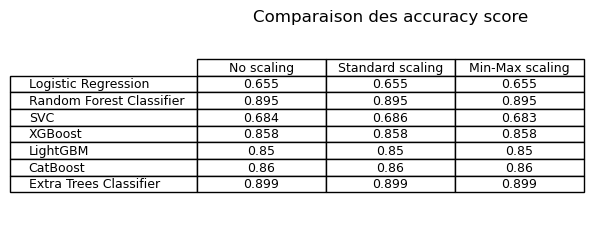

In [18]:
# Comparaison du accuracy score
accuracy_scores_default_all = [accuracy_scores_default.values(), accuracy_scores_default_ss.values(), accuracy_scores_default_mm.values()]
accuracy_scores_default_all = np.array([np.round(list(i),3) for i in accuracy_scores_default_all]).T

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5)) 
ax.axis('off')

the_table = ax.table(cellText=accuracy_scores_default_all, colLabels=['No scaling', 'Standard scaling', 'Min-Max scaling'], rowLabels=list(models.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des accuracy score')

plt.show()

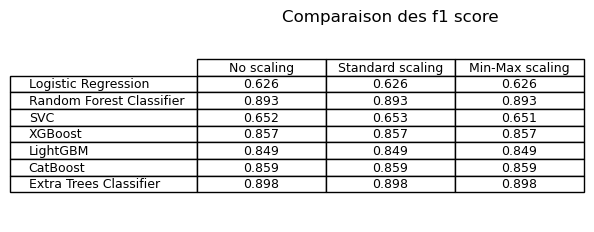

In [19]:
# Comparaison du f1 score
f1_scores_default_all = [f1_scores_default.values(), f1_scores_default_ss.values(), f1_scores_default_mm.values()]
f1_scores_default_all = np.array([np.round(list(i),3) for i in f1_scores_default_all]).T

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.axis('off')

the_table = ax.table(cellText=f1_scores_default_all, colLabels=['No scaling', 'Standard scaling', 'Min-Max scaling'], rowLabels=list(models.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des f1 score')

plt.show()